In [1]:
import glob
from PIL import Image
import cv2
from math import exp,pi,sin,cos
import numpy as np
from matplotlib import pyplot as plt
from numba import jit
import time
#import mkl_fft as fft
#内部コマンドは先頭に「!」を付ける、例：「!ls」

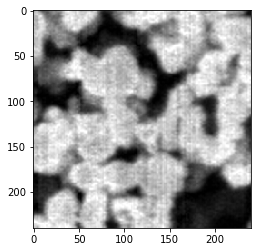

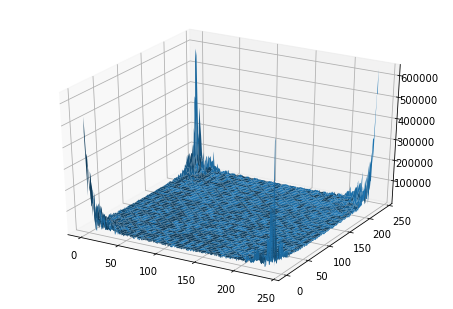

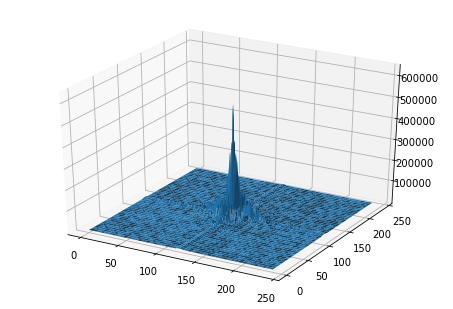

In [2]:
from mpl_toolkits.mplot3d import Axes3D
img = np.array(Image.open('/Users/shgtkmt/workspace/fourier_learning/train/0_0.tif'),'float64')
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,255))
img = scaler.fit_transform(img)
plt.imshow(img, cmap='gray')
plt.show()
'''Imageオブジェクトに戻す
img2 = Image.fromarray(img)
print(img2.size)
'''
'''２次元表示例
x = np.linspace(0, 2*pi, 100)
y = np.sin(x)
plt.plot(x, y)
plt.show()
'''
cir_ave = 0
for i in range(239):
    cir_ave += img[0,i]
    cir_ave += img[i,-1]
    cir_ave += img[-1,-i]
    cir_ave += img[-i,0]
cir_ave /= 956
img -= cir_ave
for i in range(239):
    for j in range(12):
        img[j,i] = img[j,i]*sin((2*pi*j)/12)
        img[i,-j] = img[i,-j]*sin((2*pi*j)/12)
        img[-j,-i] = img[-j,-i]*sin((2*pi*j)/12)
        img[-i,j] = img[-i,j]*sin((2*pi*j)/12)
with open('./demo/demo.txt','w') as f:
    for y in range(240):
        for x in range(240):
            f.write(str(img[y,x]) + ' ')
        f.write('\n')
        
img = np.fft.fft2(img)
x = np.arange(0,240,1) #下と同じ
y = np.linspace(0, 240, 240) #上と同じ
_x, _y = np.meshgrid(x,y)
fig = plt.figure()
ax = Axes3D(fig)
ax.plot_surface(_x,_y,np.absolute(img))
plt.show()

img = np.fft.fftshift(img)
fig = plt.figure()
ax = Axes3D(fig)
ax.plot_surface(_x,_y,np.absolute(img))
plt.show()

# 3ch画像の調査
img = cv2.imread('./3ch/0_0.tiff')
def print_position(event, x, y, flags,param):
    if event == cv2.EVENT_LBUTTONDBLCLK:
        print(img[y,x,:])
cv2.namedWindow('img')
cv2.setMouseCallback('img', print_position)
cv2.imshow('img',img)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [102]:
# cuda無し
#フーリエあり

start = time.time()
train_path = glob.glob("/Users/shgtkmt/workspace/cnn_fourier/train//*.tif")
test_path = glob.glob("/Users/shgtkmt/workspace/cnn_fourier/train//*.tif")

def a0edge_rm(local_f,x,y):
    arr = local_f
    cir_ave = 0
    num = 0
    if x < 8:
        empty_range_x = 8 - x
    else:
        empty_range_x = False
    if 248-1 < x+15:
        empty_range_x2 = (x+16) - 248
    else:
        empty_range_x2 = False
    flag_x = not(empty_range_x or empty_range_x2) #x方向での0パディング領域が存在しない == true
    if y < 8:
        empty_range_y = 8 - y
    else:
        empty_range_y = False
    if 248-1 < y+15:
        empty_range_y2 = (y+16) - 248
    else:
        empty_range_y2 = False
    flag_y = not(empty_range_y or empty_range_y2) #y方向での0パディング領域が存在しない == true
    if (flag_x and flag_y): #０パディング領域が存在しない場合
        for k in range(15):
            cir_ave += arr[0,k]
            cir_ave += arr[k,-1]
            cir_ave += arr[-1,-k]
            cir_ave += arr[-k,0]
        num = 60
        cir_ave /= num
        arr -= cir_ave
    elif (not(flag_x) and flag_y): #x方向のみに０パディング領域が存在する場合
        if (empty_range_x): #左側が０パディング
            for k in range(16 - empty_range_x):
                cir_ave += arr[0,k+empty_range_x]
                num += 1
                cir_ave += arr[-1,k+empty_range_x]
                num += 1
            for k in range(14):
                cir_ave += arr[1+k, empty_range_x]
                num += 1
                cir_ave += arr[1+k, -1]
                num += 1
            cir_ave /= num
            arr[:, empty_range_x:] -= cir_ave
        else: #右側が０パディング
            for k in range(16 - empty_range_x2):
                cir_ave += arr[0,k]
                num += 1
                cir_ave += arr[-1,k]
                num += 1
            for k in range(14):
                cir_ave += arr[1+k, 0]
                num += 1
                cir_ave += arr[1+k, -empty_range_x2]
                num += 1
            cir_ave /= num
            arr[:, :-empty_range_x2] -= cir_ave
    elif (flag_x and not(flag_y)): #y方向のみに０パディング領域が存在する場合
        if (empty_range_y): #上側が０パディング
            for k in range(16 - empty_range_y):
                cir_ave += arr[k+empty_range_y, 0]
                num += 1
                cir_ave += arr[k+empty_range_y, -1]
                num += 1
            for k in range(14):
                cir_ave += arr[empty_range_y, 1+k]
                num += 1
                cir_ave += arr[-1, 1+k]
                num += 1
            cir_ave /= num
            arr[empty_range_y:, :] -= cir_ave
        else: #下側が０パディング
            for k in range(16 - empty_range_y2):
                cir_ave += arr[k,0]
                num += 1
                cir_ave += arr[k,-1]
                num += 1
            for k in range(14):
                cir_ave += arr[0, 1+k]
                num += 1
                cir_ave += arr[-empty_range_y2, 1+k]
                num += 1
            cir_ave /= num
            arr[:-empty_range_y2, :] -= cir_ave
    else: #x、y方向ともに０パディング領域が存在する場合
        if(empty_range_x):#左側が０パディング領域
            if(empty_range_y):#左上側が０パディング領域
                for k in range(16 - empty_range_x):
                    cir_ave += arr[empty_range_y, k+empty_range_x]
                    num += 1
                    cir_ave += arr[-1, k+empty_range_x]
                    num += 1
                for k in range(14 - empty_range_y):
                    cir_ave += arr[k+empty_range_y+1, empty_range_x]
                    num += 1
                    cir_ave += arr[k+empty_range_y+1, -1]
                    num += 1
                cir_ave /= num
                arr[empty_range_y:, empty_range_x:] -= cir_ave
            else:#左下側が０パディング領域
                for k in range(16 - empty_range_x):
                    cir_ave += arr[0, k+empty_range_x]
                    num += 1
                    cir_ave += arr[-empty_range_y2, k+empty_range_x]
                    num += 1
                for k in range(14 - empty_range_y2):
                    cir_ave += arr[k, empty_range_x]
                    num += 1
                    cir_ave += arr[k, -1]
                    num += 1
                cir_ave /= num
                arr[:-empty_range_y2, empty_range_x:] -= cir_ave
        else:#右側が０パディング領域
            if(empty_range_y2):#右下が０パディング領域
                for k in range(16 - empty_range_x2):
                    cir_ave += arr[0, k]
                    num += 1
                    cir_ave += arr[-empty_range_y2, k]
                    num += 1
                for k in range(14 - empty_range_y2):
                    cir_ave += arr[k+1, 0]
                    num += 1
                    cir_ave += arr[k+1, -empty_range_x2]
                    num += 1
                cir_ave /= num
                arr[:-empty_range_y2, :-empty_range_x2] -= cir_ave
            else:#右上が０パディング領域
                for k in range(16 - empty_range_x2):
                    cir_ave += arr[empty_range_y, k]
                    num += 1
                    cir_ave += arr[-1, k]
                    num += 1
                for k in range(14 - empty_range_y):
                    cir_ave += arr[k+1+empty_range_y, 0]
                    num += 1
                    cir_ave += arr[k+1+empty_range_y, -empty_range_x2]
                    num += 1
                cir_ave /= num
                arr[empty_range_y:, :-empty_range_x2] -= cir_ave
    return arr

@jit
def myfourier(tiff_path):
    pre_img =  Image.open(tiff_path)
    pre_img = pre_img.convert('L')
    _x = pre_img.size[0]
    _y = pre_img.size[1]
    pre_img =  np.array(pre_img)
    X = np.zeros([1, _y, _x, 5],'float32')
    X[0,:,:,0] = pre_img
    img = np.zeros([_y+16, _x+16])
    img[8:-8, 8:-8] = pre_img
    local_f = np.zeros([17,17])
    cir_ave = 0
    for y in range(_y):
        for x in range(_x):
            local_f = img[y:y+17, x:x+17]
            #local_f = a0edge_rm(local_f,x,y)
            local_f = np.fft.fft2(local_f)
            #local_f = fft.fft2(local_f)
            local_f = np.fft.fftshift(local_f)
            for i in range(17):
                for j in range(17):
                    local_f[i,j] = np.absolute(local_f[i,j])
            X[0,y,x,4] = local_f.sum()#289
            X[0,y,x,3] = local_f[2:15, 2:15].sum()#169
            X[0,y,x,4] = (X[0,y,x,4] - X[0,y,x,3])
            X[0,y,x,2] = local_f[4:13, 4:13].sum()#81
            X[0,y,x,3] = (X[0,y,x,3] - X[0,y,x,2])
            X[0,y,x,1] = local_f[6:11, 6:11].sum()#25
            X[0,y,x,2] = (X[0,y,x,2] - X[0,y,x,1])
            X[0,y,x,1] = X[0,y,x,1] - local_f[8,8]
            X[0,y,x,1] = X[0,y,x,1]/24
            X[0,y,x,2] = X[0,y,x,2]/56
            X[0,y,x,3] = X[0,y,x,3]/88
            X[0,y,x,4] = X[0,y,x,4]/120
    return X

data_num = (len(train_path) - 1) - 26
X = myfourier(train_path[0])
for i in range(data_num):
    X = np.append(X,myfourier(train_path[i+1]),axis=0)
    
data_num = (len(test_path)-1 )-150
Xte = myfourier(test_path[150])
for i in range(data_num):
    Xte = np.append(Xte,myfourier(test_path[i+151]),axis=0)
    
caltime = time.time() - start
print(X.shape,Xte.shape,caltime/60)

C:\Users\shgtkmt\Anaconda3\envs\deep-learning\lib\site-packages\ipykernel_launcher.py:188: ComplexWarning: Casting complex values to real discards the imaginary part
C:\Users\shgtkmt\Anaconda3\envs\deep-learning\lib\site-packages\ipykernel_launcher.py:190: ComplexWarning: Casting complex values to real discards the imaginary part
C:\Users\shgtkmt\Anaconda3\envs\deep-learning\lib\site-packages\ipykernel_launcher.py:193: ComplexWarning: Casting complex values to real discards the imaginary part
C:\Users\shgtkmt\Anaconda3\envs\deep-learning\lib\site-packages\ipykernel_launcher.py:195: ComplexWarning: Casting complex values to real discards the imaginary part


(150, 240, 240, 5) (26, 240, 240, 5) 85.82504359086354


In [2]:
#フーリエ無し

def origin_data(path):
    img = Image.open(path)
    _x = int(img.size[0])
    _y = int(img.size[1])
    noX = np.zeros([1,_y,_x,1])
    noX[0,:,:,0] = np.array(img)
    return noX

train_path = glob.glob("/Users/shgtkmt/workspace/cnn_fourier/train//*.tif")
data_num = (len(train_path) - 1) - 26
noX = origin_data(train_path[0])
for i in range(data_num):
    noX = np.append(noX,origin_data(train_path[i+1]),axis=0)
    
test_path = glob.glob("/Users/shgtkmt/workspace/cnn_fourier/train//*.tif")
data_num = (len(test_path)-1 ) -150
noXte = origin_data(test_path[150])
for i in range(data_num):
    noXte = np.append(noXte,origin_data(test_path[i+151]),axis=0)
    
print(noX.shape,noXte.shape)

(150, 240, 240, 1) (26, 240, 240, 1)


In [3]:
start = time.time()
'''
with open("./../data/cnn_Fourier/X.txt", "w") as f:
    for num in range(X.shape[0]):
        f.write('flag0\n')
        for row in range(X.shape[1]):
            f.write('flag1\n')
            for column in range(X.shape[2]):
                f.write('flag2\n')
                for ch in range(X.shape[3]):
                    f.write(str(X[num,row,column,ch]))
                    f.write('\n')
                    
with open("./../data/cnn_Fourier/Xte.txt", "w") as f:
    for num in range(Xte.shape[0]):
        f.write('flag0\n')
        for row in range(Xte.shape[1]):
            f.write('flag1\n')
            for column in range(Xte.shape[2]):
                f.write('flag2\n')
                for ch in range(Xte.shape[3]):
                    f.write(str(Xte[num,row,column,ch]))
                    f.write('\n')

#'''
#'''
X = np.zeros([150,240,240,5],'float32')
with open("./../data/cnn_Fourier/X.txt", "r") as f:
    num=-1
    row=-1
    column=-1
    ch=0
    for line in f:
        if (line.find('flag0') == 0):
            num += 1
            row = -1
        elif (line.find('flag1') == 0):
            row += 1
            column = -1
        elif (line.find('flag2') == 0):
            column += 1
            ch = 0
        else:
            X[num,row,column,ch] = float(line)
            ch += 1
        
Xte = np.zeros([26,240,240,5],'float32')
with open("./../data/cnn_Fourier/Xte.txt", "r") as f:
    num=-1
    row=-1
    column=-1
    ch=0
    for line in f:
        if (line.find('flag0') == 0):
            num += 1
            row = -1
        elif (line.find('flag1') == 0):
            row += 1
            column = -1
        elif (line.find('flag2') == 0):
            column += 1
            ch = 0
        else:
            Xte[num,row,column,ch] = float(line)
            ch += 1
#'''
caltime = time.time() - start
print(X.shape,Xte.shape,caltime/60)

(150, 240, 240, 5) (26, 240, 240, 5) 1.1087668538093567


In [45]:
# fftをcudaで（途中）

from numba import cuda
from accelerate.cuda import fft
grid = (8,8)
block = (32,32) 
#240,240が良いが、最大スレッド数がgtx1060は１グリッドあたり1024個で、warp的に32の倍数にしている
#x, y = cuda.grid(2)

train_path = glob.glob("/Users/shgtkmt/workspace/cnn_fourier/train//*.tif")
test_path = glob.glob("/Users/shgtkmt/workspace/cnn_fourier/train//*.tif")
img =  Image.open(train_path[0])
img = img.convert('L')
img =  np.asarray(img)


#fft.fft(img, _out)


In [4]:
# 2値化教師データ

def mask_check(mask_path):
    mask = Image.open(mask_path)
    _x = int(mask.size[0])
    _y = int(mask.size[1])
    Y = np.zeros([1, _y, _x])
    mask = np.array(mask)
    for y in range(_y):
        for x in range(_x):
            if(mask[y,x]):
                Y[0,y,x] = 1
    return Y

train_ans_path = glob.glob("/Users/shgtkmt/workspace/cnn_fourier/train_ans//*.tif")
test_ans_path = glob.glob("/Users/shgtkmt/workspace/cnn_fourier/train_ans//*.tif")

data_num = (len(train_ans_path) - 1) - 26
Y = mask_check(train_ans_path[0])
for i in range(data_num):
    Y = np.append(Y,mask_check(train_ans_path[i+1]),axis=0)

data_num = (len(test_ans_path)-1) -150
Yte = mask_check(test_ans_path[150])
for i in range(data_num):
    Yte = np.append(Yte,mask_check(test_ans_path[i+151]),axis=0)

print(Y.shape,Yte.shape)

(150, 240, 240) (26, 240, 240)


In [5]:
# 3値化教師データ

ans3ch_path = glob.glob("/Users/shgtkmt/workspace/cnn_fourier/3ch/*.tiff")
ch_num = len(ans3ch_path)
ch = np.zeros((ch_num, 240, 240))
flag = 0
check = [243,168,0]
img = cv2.imread(ans3ch_path[0])
ch_num -= 1
for y in range(240):
    for x in range(240):
        for i in range(3):
            if img[y,x,i] == check[i]:
                flag += 1
        if flag == 3:
            ch[0,y,x] = 1
        flag = 0
for n in range(ch_num):
    img = cv2.imread(ans3ch_path[n+1])
    for y in range(240):
        for x in range(240):
            for i in range(3):
                if img[y,x,i] == check[i]:
                    flag += 1
            if flag == 3:
                ch[n+1,y,x] = 1
            flag = 0
            
print(ch.shape)
chY = np.zeros([150,240,240,1])
chY[:,:,:,0] = Y[:,:,:]
chY = np.append(chY, ch[:150:,:,:].reshape([150,240,240,1]), axis=3)
chYte = np.zeros([26,240,240,1])
chYte[:,:,:,0] = Yte[:,:,:]
chYte = np.append(chYte, ch[-26:,:,:].reshape([26,240,240,1]), axis=3)
del ch
print(chY.shape,chYte.shape)

(176, 240, 240)
(150, 240, 240, 2) (26, 240, 240, 2)


In [217]:
# FCN
from keras.layers import Input, Activation #,Dropout
from keras.layers.core import Reshape
from keras.layers.convolutional import Conv2D, UpSampling2D
from keras.layers.pooling import MaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.layers.advanced_activations import ThresholdedReLU, LeakyReLU
from keras.layers.merge import Concatenate, Add

#フーリエ無(240,240,1) フーリエ有(240,240,5)
input_img = Input(shape=(240,240,5))
'''
目的：各ピクセルのフーリエ領域をまとめる
[x = Conv2D(1, (17, 17), padding='same')(input_img)]
[x = Conv2D(5, (17, 17), padding='same')(input_img)]
でもいい気がするがやはりチャネルは増やした方がいい
    = 人が思いもつかない高次元特徴を抽出できる
'''
x = Conv2D(10, (17, 17), padding='same')(input_img)
#x = Dropout(0.1)(x) segmentationにおいてdropoutは特に意味はない
# 目的：よりローカルな情報にする
x = Conv2D(10, (9, 9), padding='same')(x)
x = BatchNormalization()(x)
x = LeakyReLU(alpha=0.1)(x)
x1 = MaxPooling2D(pool_size=(5, 5))(x) #shape=(48,48,10)
# 目的：ローカルとフローバルの繋ぎ
x = Conv2D(15, (5, 5), padding='same')(x1)
x = BatchNormalization()(x)
x = LeakyReLU(alpha=0.2)(x)
x2 = MaxPooling2D(pool_size=(2, 2))(x) #shape=(24,24,15)
# 目的：グローバルな情報
x = Conv2D(20, (3, 3), padding='same')(x2)
x = BatchNormalization()(x)
x = LeakyReLU(alpha=0.2)(x)
x = MaxPooling2D(pool_size=(2, 2))(x) #shape=(12,12,20)
# 目的：よりグローバルな情報というよりチャンネル合わせ
x = Conv2D(25, (2, 2), padding='same')(x)
x = BatchNormalization()(x)
x = LeakyReLU(alpha=0.2)(x)
#upsampling
x = UpSampling2D((2, 2))(x) #shape=(24,24,25)
x = Concatenate()([x2, x])
x = Conv2D(20, (3, 3), padding='same')(x)
x = BatchNormalization()(x)
x = LeakyReLU(alpha=0.2)(x)
x = UpSampling2D((2, 2))(x) #shape=(80,80,20)
x = Concatenate()([x1, x])
x = Conv2D(5, (5, 5), padding='same')(x)
x = BatchNormalization()(x)
x = LeakyReLU(alpha=0.1)(x)
x = UpSampling2D((5, 5))(x)

#fin 2値化か3値化の選択
x = Conv2D(2,(9, 9), padding='same')(x)
x = Reshape((240,240,2))(x)

x = Activation('sigmoid')(x)
x = ThresholdedReLU(theta=0.5)(x)
out = x

from keras.models import Model
model = Model(input_img, out)
model.compile(loss="binary_crossentropy", 
              optimizer='adam',
             metrics=['accuracy'])

In [218]:
model.fit(X, chY, epochs=10, batch_size=10, validation_split=0)

#フーリエ有
#model.load_weights('./img/weights2.h5', by_name=False) # 2値化
#model.load_weights('./img/weights3.h5', by_name=False) # 3値化
#フーリエ無
#model.load_weights('./img/weights2_nothing.h5', by_name=False) #2値化
#model.load_weights('./img/weights3_nothing.h5', by_name=False) #3値化

Epoch 1/10
150/150 [==============================] - 4s - loss: 2.1164 - acc: 0.6937     
Epoch 2/10
150/150 [==============================] - 1s - loss: 1.3525 - acc: 0.8774     
Epoch 3/10
150/150 [==============================] - 1s - loss: 1.1011 - acc: 0.8888     
Epoch 4/10
150/150 [==============================] - 1s - loss: 1.0644 - acc: 0.8952     
Epoch 5/10
150/150 [==============================] - 1s - loss: 1.0404 - acc: 0.8992     
Epoch 6/10
150/150 [==============================] - 1s - loss: 1.0109 - acc: 0.9014     
Epoch 7/10
150/150 [==============================] - 1s - loss: 1.0123 - acc: 0.9028     
Epoch 8/10
150/150 [==============================] - 1s - loss: 1.0389 - acc: 0.9041     
Epoch 9/10
150/150 [==============================] - 1s - loss: 1.0249 - acc: 0.9044     
Epoch 10/10
150/150 [==============================] - 1s - loss: 1.0065 - acc: 0.9049     


In [213]:
loss_and_metrics = model.evaluate(Xte,chYte)
print("\n{} loss:{} accuracy:{}".format(len(loss_and_metrics),loss_and_metrics[0],loss_and_metrics[1]))
print(model.summary())
#from keras.utils import plot_model
#plot_model(model, to_file='./img/model.png', show_shapes=True)

#フーリエ有
#model.save_weights('./img/weights2.h5') #2値化
#model.save_weights('./img/weights3.h5') #3値化
#フーリエ無
#model.save_weights('./img/weights2_nothing.h5') #2値化
#model.save_weights('./img/weights3_nothing.h5') #3値化

26/26 [==============================] - 2s

2 loss:0.9042120575904846 accuracy:0.8808408975601196
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_35 (InputLayer)            (None, 240, 240, 5)   0                                            
____________________________________________________________________________________________________
conv2d_273 (Conv2D)              (None, 240, 240, 10)  14460       input_35[0][0]                   
____________________________________________________________________________________________________
conv2d_274 (Conv2D)              (None, 240, 240, 10)  8110        conv2d_273[0][0]                 
____________________________________________________________________________________________________
batch_normalization_205 (BatchNo (None, 240, 240, 10)  40          conv2d_274[0][0]          

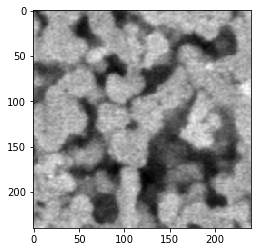

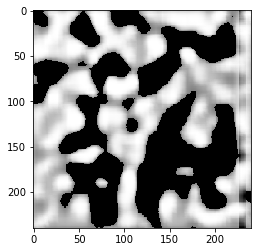

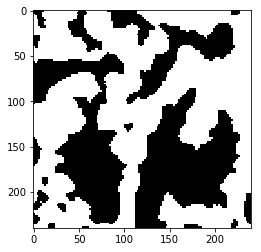

In [525]:
# 2値化出力

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,255))
plt.imshow(Xte[12,:,:,0], cmap='gray')
plt.show()
ans = model.predict_on_batch(Xte)
img = scaler.fit_transform(ans[12,:,:])
plt.imshow(img, cmap='gray')
plt.show()
plt.imshow(Yte[12,:,:], cmap='gray')
plt.show()

for i in range(26):
    img = Image.fromarray(ans[i,:,:])
    img.save('./../results/result_' + str(i) + '.tiff')

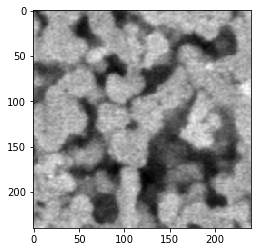

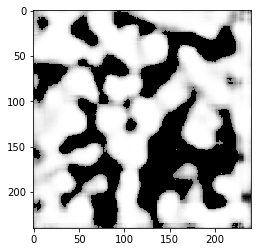

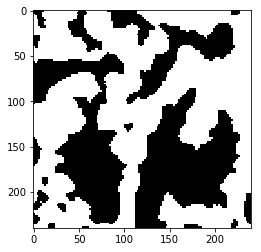

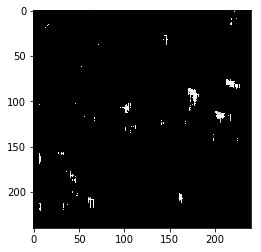

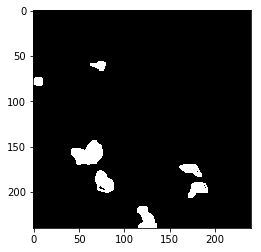

In [219]:
# ３値化出力

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,255))
plt.imshow(Xte[12,:,:,0], cmap='gray')
plt.show()
ans = model.predict_on_batch(Xte)
img1 = scaler.fit_transform(ans[12,:,:,0])
img2 = scaler.fit_transform(ans[12,:,:,1])
plt.imshow(img1, cmap='gray')
plt.show()
plt.imshow(chYte[12,:,:,0], cmap='gray')
plt.show()
plt.imshow(img2, cmap='gray')
plt.show()
plt.imshow(chYte[12,:,:,1], cmap='gray')
plt.show()

for i in range(26):
    img1 = Image.fromarray(ans[i,:,:,0])
    img1.save('./../results/result1_' + str(i) + '.tiff')
    img2 = Image.fromarray(ans[i,:,:,1])
    img2.save('./../results/result2_' + str(i) + '.tiff')

In [526]:
# ２値化での全領域の精度確認

tp_all = 0
tn_all = 0
fp_all = 0
fn_all = 0
_sum_all = 0
for n in range(26):
    for y in range(240):
        for x in range(240):
            if(ans[n,y,x]>=0.5 and Yte[n,y,x]==1):
                #true positive
                tp_all += 1
                _sum_all += 1
            elif(ans[n,y,x]<0.5 and Yte[n,y,x]==0):
                #true negative
                tn_all += 1
                _sum_all += 1
            elif(ans[n,y,x]>=0.5 and Yte[n,y,x]==0):
                #false positive
                fp_all += 1
                _sum_all += 1
            elif(ans[n,y,x]<0.5 and Yte[n,y,x]==1):
                #false negative
                fn_all += 1
                _sum_all += 1
            else:
                print('error')
print(tp_all,tn_all,fp_all,fn_all,(tp_all+tn_all)/(_sum_all))

921379 377019 149609 49593 0.866985844017094


In [527]:
# ２値化での対象領域のみ精度確認

tp = 0
tn = 0
fp = 0
fn = 0
_sum = 0
for n in range(26):
    for y in range(240):
        for x in range(240):
            if(chYte[n,y,x,1] == 1):
                if(ans[n,y,x]>=0.5 and Yte[n,y,x]==1):
                    #true positive
                    tp += 1
                    _sum += 1
                elif(ans[n,y,x]<0.5 and Yte[n,y,x]==0):
                    #true negative
                    tn += 1
                    _sum += 1
                elif(ans[n,y,x]>=0.5 and Yte[n,y,x]==0):
                    #false positive
                    fp += 1
                    _sum += 1
                elif(ans[n,y,x]<0.5 and Yte[n,y,x]==1):
                    #false negative
                    fn += 1
                    _sum += 1
                else:
                    print('error')
print(tp,tn,fp,fn,(tp+tn)/(_sum))

1252 26549 30981 221 0.47117943155432773


In [220]:
# ３値化での全領域の精度確認

tp_all = 0
tn_all = 0
fp_all = 0
fn_all = 0
_sum_all = 0
for c in range(2):
    for n in range(26):
        for y in range(240):
            for x in range(240):
                if(ans[n,y,x,c]>=0.5 and chYte[n,y,x,c]==1):
                    #true positive
                    tp_all += 1
                    _sum_all += 1
                elif(ans[n,y,x,c]<0.5 and chYte[n,y,x,c]==0):
                    #true negative
                    tn_all += 1
                    _sum_all += 1
                elif(ans[n,y,x,c]>=0.5 and chYte[n,y,x,c]==0):
                    #false positive
                    fp_all += 1
                    _sum_all += 1
                elif(ans[n,y,x,c]<0.5 and chYte[n,y,x,c]==1):
                    #false negative
                    fn_all += 1
                    _sum_all += 1
                else:
                    print('error')
    print(tp_all,tn_all,fp_all,fn_all,(tp_all+tn_all)/(_sum_all))
    tp_all = 0
    tn_all = 0
    fp_all = 0
    fn_all = 0
    _sum_all = 0

943585 314056 212572 27387 0.8397709668803419
493 1410731 27866 58510 0.9423237179487179


In [221]:
# ３値化での特定の領域の精度確認

tp = 0
tn = 0
fp = 0
fn = 0
_sum = 0
for c in range(2):
    for n in range(26):
        for y in range(240):
            for x in range(240):
                if(chYte[n,y,x,1] == 1):
                    if(ans[n,y,x,c]>=0.5 and chYte[n,y,x,c]==1):
                        #true positive
                        tp += 1
                        _sum += 1
                    elif(ans[n,y,x,c]<0.5 and chYte[n,y,x,c]==0):
                        #true negative
                        tn += 1
                        _sum += 1
                    elif(ans[n,y,x,c]>=0.5 and chYte[n,y,x,c]==0):
                        #false positive
                        fp += 1
                        _sum += 1
                    elif(ans[n,y,x,c]<0.5 and chYte[n,y,x,c]==1):
                        #false negative
                        fn += 1
                        _sum += 1
                    else:
                        print('error')
    print(tp,tn,fp,fn,(tp+tn)/(_sum))
    tp = 0
    tn = 0
    fp = 0
    fn = 0
    _sum = 0

1326 12591 44939 147 0.23586936257478433
493 0 0 58510 0.008355507347084047
